# Travel Insurance Purchase Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold,
    KFold,
)
from scipy.stats import mannwhitneyu, chi2_contingency
from phik import phik_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    LabelEncoder,
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from itertools import product
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.functions import *

# Dataset Cleaning

The main objectives for this part of the notebook are:

- Get familiar with the dataset.
- Discover common data quality issues.
- Address the data quality issues.

I will set aside 15% of the data for an unbiased assessment of the model's performance at the end of the project.

In [2]:
customers_raw = pd.read_csv('TravelInsurancePrediction.csv', index_col=0)
customers, customers_holdout_test = train_test_split(
    customers_raw,
    test_size=0.15,
    random_state=5,
    stratify=customers_raw['TravelInsurance'],
)

## Table Contents

The dataset is a single CSV file.

In [3]:
rows, columns = customers.shape
print(f'{rows} rows and {columns} columns.')
customers.head()

1688 rows and 9 columns.


,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
1193,34,Private Sector/Self Employed,No,950000,3,0,No,No,0
754,32,Government Sector,Yes,850000,3,0,No,No,0
1470,33,Government Sector,Yes,1100000,4,0,No,No,0
1475,28,Government Sector,Yes,300000,4,0,No,No,0
1254,34,Private Sector/Self Employed,Yes,700000,8,0,No,No,1


Observations:

- The dataset contains 8 predictor variables and 1 target variable "TravelInsurance".
- There are 1688 customers in the dataset.
- The dataset has 5 binary categorical features, 3 discrete numerical features and a binary target.

To check for the last point, I inspected the distributions of all features. For conciseness, this information will be presented during EDA.

## Missing Values

In [4]:
customers.isnull().any().any()

np.False_

Observations:

- No missing values.

## Duplicates

The customers are not identified by any ID number, and we only have their status. I will check the percentage of duplicated rows.

In [5]:
print(f'{round(len(customers[customers.duplicated(keep=False)])*100/len(customers))}%')

53%


Observations:

- In the dataset, around 54% of customers have duplicate entries. Excluding the first occurrence of each duplicate row reduces this percentage to 35%.
- Due to the limited number and binary nature of several variables, duplicate rows may represent legitimate clients. Since there are no origin or collection details about this dataset, it is unclear if duplicates are errors or even repeated offers to the same clients.

Impact:
- I will assume duplicates are valid clients and not errors.

Do both "TravelInsurance" classes have the same amount of duplicates?

In [6]:
no_group = customers[customers['TravelInsurance'] == 0]
yes_group = customers[customers['TravelInsurance'] == 1]
no_group_duplicate_ratio = (
    len(no_group[no_group.duplicated(keep=False)]) * 100 / len(no_group)
)
yes_group_duplicate_ratio = (
    len(yes_group[yes_group.duplicated(keep=False)]) * 100 / len(yes_group)
)
print(f'Duplicated rows for "No" class: {round(no_group_duplicate_ratio)}%')
print(f'Duplicated rows for "Yes" class: {round(yes_group_duplicate_ratio)}%')

Duplicated rows for "No" class: 57%
Duplicated rows for "Yes" class: 47%


Observations:

- The ratios of duplicates for both classes are close enough and there does not appear to be a pattern.

We will check if dropping the duplicates changes the association between the target and predictors. The Phik ($\phi_K$) correlation coefficient measures the strength of association between variables, similar to the Pearson correlation for continuous data, but it is adapted for categorical and mixed data types (it converts numeric variables into categorical ones). $\phi_K$ values range from 0 to 1, where 0 indicates no association and 1 indicates a perfect association.


In [7]:
numerical_cols = ['Age', 'AnnualIncome', 'FamilyMembers']
phik_matrix_original = customers.phik_matrix(interval_cols=numerical_cols)
phik_original = phik_matrix_original['TravelInsurance']
customers_deduplicated = customers.drop_duplicates()
phik_matrix_deduplicated = customers_deduplicated.phik_matrix(
    interval_cols=numerical_cols
)
phik_deduplicated = phik_matrix_deduplicated['TravelInsurance']
pd.DataFrame(
    {
        'Feature': phik_original.index,
        'Phik_Original': phik_original.values,
        'Phik_Deduplicated': phik_deduplicated.values,
    }
)

,Feature,Phik_Original,Phik_Deduplicated
0,Age,0.370731,0.245525
1,Employment Type,0.246737,0.149602
2,GraduateOrNot,0.000000,0.000000
3,AnnualIncome,0.705441,0.563394
4,FamilyMembers,0.134140,0.126437
5,ChronicDiseases,0.037335,0.000000
6,FrequentFlyer,0.337728,0.201078
7,EverTravelledAbroad,0.652134,0.490495
8,TravelInsurance,1.000000,1.000000


Observations:
- Dropping duplicates changes the predictor's influence on the target.

Impact:
- Since the total amount of data is relatively low, I will keep the duplicates but ensure no data leakage by guaranteeing that duplicate rows do not appear in both the training and test sets.

Example:

- Train set: A, A, B, C, D
- Test set: E, F, F, F, G

## Data Types

In [8]:
customers.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

Observations:
- Categorical features are stored as objects.
- "ChronicDiseases" and "TravelInsurance" are binary categorical, but are stored as int64.

Impact:
- For performance and ease of management, objects and integer types that have two values will be converted to categories.

In [9]:
customers = customers.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col
)
binary_columns = ['ChronicDiseases', 'TravelInsurance']
customers[binary_columns] = customers[binary_columns].apply(
    lambda col: col.astype('category')
)
customers['ChronicDiseases'] = customers['ChronicDiseases'].cat.rename_categories(
    {0: 'No', 1: 'Yes'}
)
customers['TravelInsurance'] = customers['TravelInsurance'].cat.rename_categories(
    {0: 'No', 1: 'Yes'}
)

## Entry Errors

Categorical feature values:

In [10]:
for col in customers.select_dtypes(include='category').columns:
    unique_values = customers[col].cat.categories.tolist()
    print(f'Categories in {col}: {unique_values}')

Categories in Employment Type: ['Government Sector', 'Private Sector/Self Employed']
Categories in GraduateOrNot: ['No', 'Yes']
Categories in ChronicDiseases: ['No', 'Yes']
Categories in FrequentFlyer: ['No', 'Yes']
Categories in EverTravelledAbroad: ['No', 'Yes']
Categories in TravelInsurance: ['No', 'Yes']


Observations:
- All categorical variables have two categories.

Numeric features:

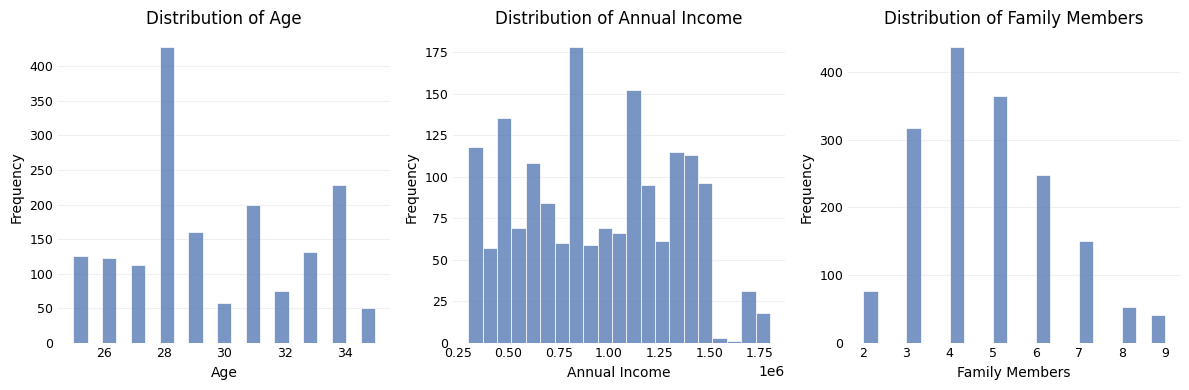

In [11]:
sns.set_palette('deep')
numeric_features = customers.select_dtypes(include=['number'])
fig, axes = plt.subplots(1, len(numeric_features.columns), figsize=(12, 4))
for ax, col in zip(axes, numeric_features.columns):
    name = insert_space_before_capitals(col)
    sns.histplot(
        customers[col], bins=21, ax=ax, zorder=2, edgecolor='white', linewidth=0.5
    )
    ax.set_title(f"Distribution of {name}")
    ax.set_xlabel(name)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='both', labelsize=9, length=0)
    ax.grid(alpha=0.2, axis='y', zorder=0)
    sns.despine(left=True, bottom=True)
plt.tight_layout()

Observatios:
- No clear anomalies.

## Summary

The dataset is relatively clean, with no anomalous or missing values. The primary issue is widespread duplication of entries, comprising more than half of the data. This will be addressed during the modeling phase.

# EDA

The main objectives for this part of notebook are:

- Explore and document the dataset by performing univariate and multivariate analyses.
- Identify the remaining issues that need to be addressed when modeling.

## Target Variable

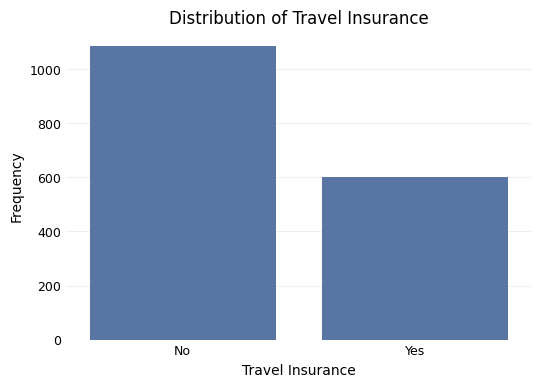

In [12]:
plt.figure(figsize=(6, 4))
name = insert_space_before_capitals('TravelInsurance')
sns.countplot(data=customers, x='TravelInsurance', zorder=2)
plt.title(f'Distribution of {name}')
plt.xlabel(f'{name}')
plt.ylabel('Frequency')
plt.tick_params(axis='both', labelsize=9, length=0)
plt.grid(alpha=0.2, axis='y', zorder=0)
sns.despine(left=True, bottom=True)

Observations:
- The feature has more "No" than "Yes" labels, but the difference is not significant and does not require addressing class imbalances.

## Relationships Between Target and Numeric Predictors

To better understand the relationships, we will visualize them with histograms and box plots. Assuming random sampling, we will employ hypothesis testing to assess the statistical significance of differences between groups. However, since our sample may not be independent (violated assumption), traditional tests are not valid. Hence, I will use a bootstrap hypothesis test for the differnece in medians between groups. For my own curiosity I will compare the results of this test with those of the Mann-Whitney U test.

Null Hypothesis (H0): There is no association between the predictor and the target variable.

Alternative Hypothesis (H1): There is an  association between the predictor and the target variable.

We will use a significance level of 0.05 to test these hypotheses. If the p-value calculated from the bootstrap test for the diffference in medians is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

Example: In the case of age and travel insurance (just below), the p-value is above the significance level. We don't reject the null hypothesis and conclude that there may not be a statistically significant relationship.

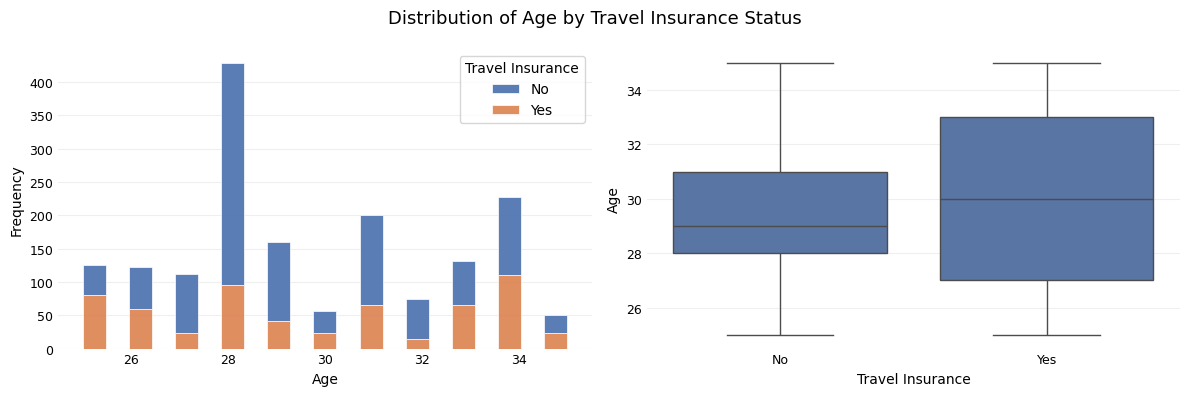

Age - Travel Insurance:
Mann-Whitney U test p-value: 0.13
Bootstrap p-value for difference in medians: 0.07



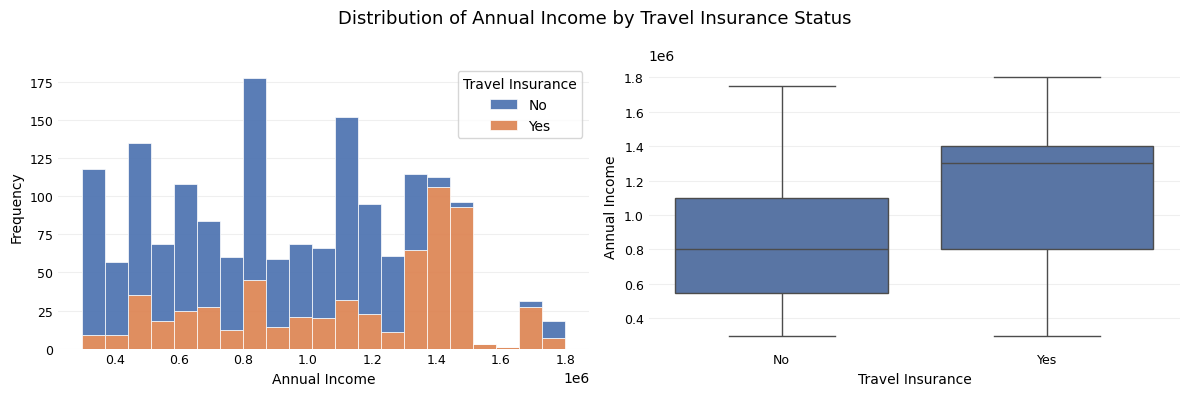

Annual Income - Travel Insurance:
Mann-Whitney U test p-value: 0.00
Bootstrap p-value for difference in medians: 0.00



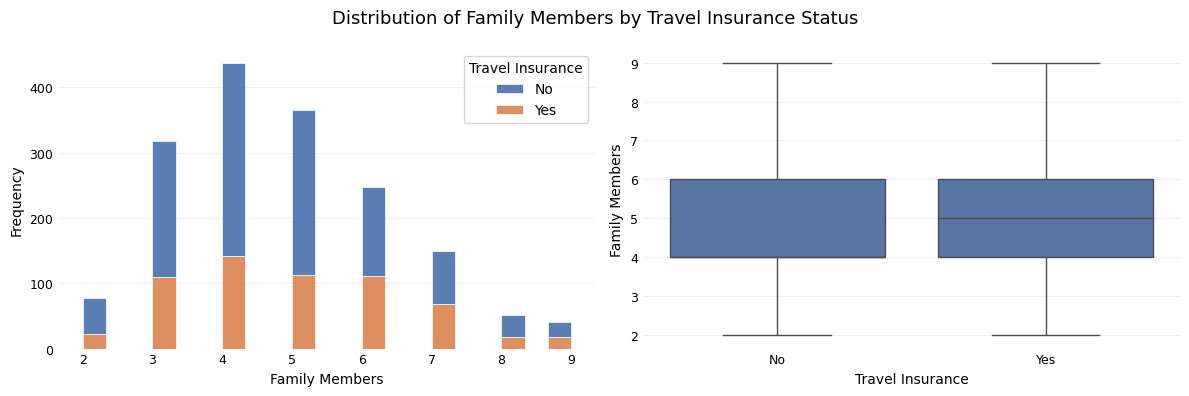

Family Members - Travel Insurance:
Mann-Whitney U test p-value: 0.00
Bootstrap p-value for difference in medians: 0.45



In [13]:
numeric_relationships(customers)

Observations:
- For the numeric predictors, only travel insurance and annual income have a statistically significant relationship. People with travel insurance tend to have higher annual incomes compared to those without travel insurance.
-  No statistically significant assosiation for age and number of family members with travel insurance.
-  Differences between Mann-Whitney U and bootstrap tests can be large. Bootstrap test should be more correct, since it does not have assumptions that can be violated.

## Relationships Between Target and Categorical Predictors

To visualize the distribution, we will use bar plots showing absolute counts to understand the number of occurrences in each category and normalized bar plots to better compare the proportions and see if there is a difference between the two groups. I will check statistical significance with the Chi-Square test. I did not use bootstrap for the difference in proportions for this part because it would have required more time to write, and the observed differences are less informative without accounting for confounding variables anyway.

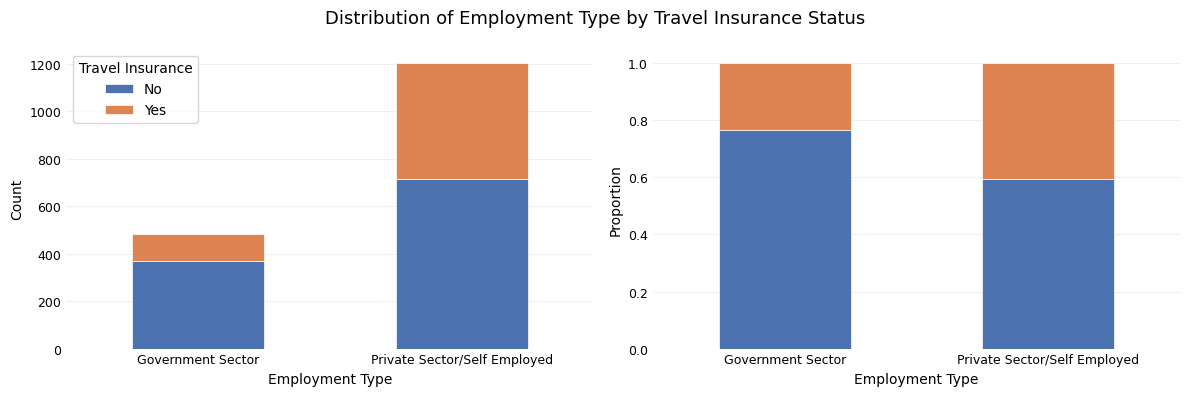

Employment Type - Travel Insurance:
Chi-Square test p-value: 0.00



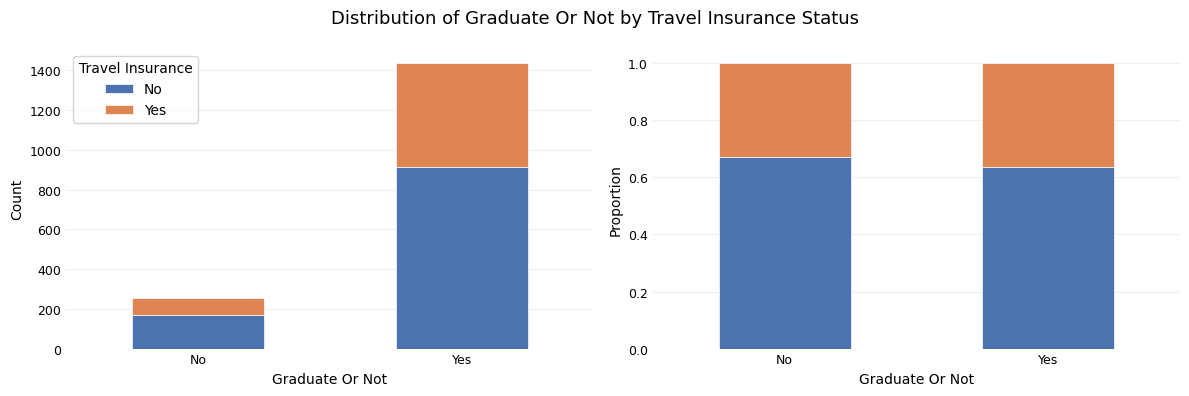

Graduate Or Not - Travel Insurance:
Chi-Square test p-value: 0.33



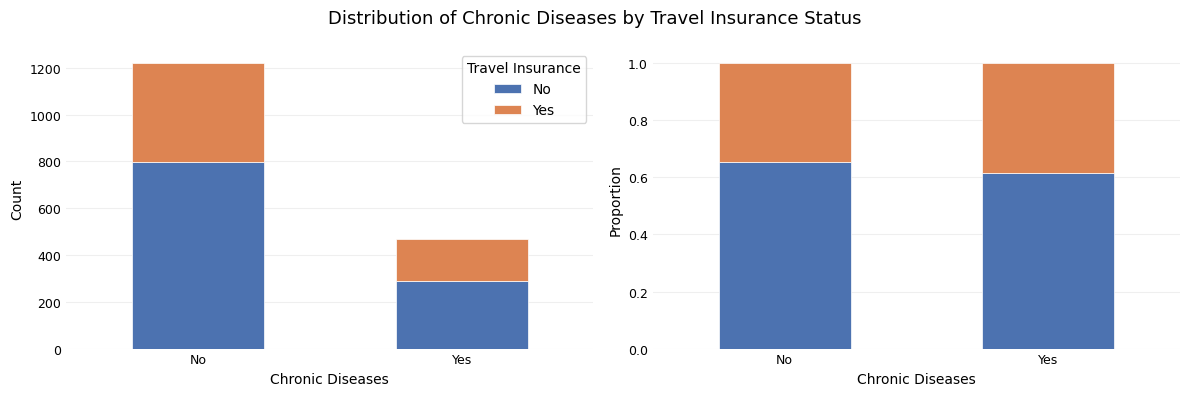

Chronic Diseases - Travel Insurance:
Chi-Square test p-value: 0.16



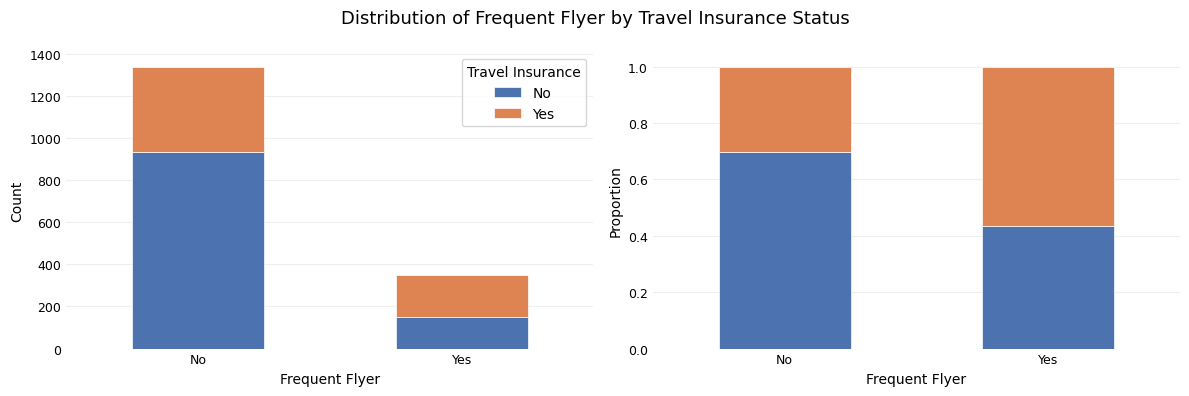

Frequent Flyer - Travel Insurance:
Chi-Square test p-value: 0.00



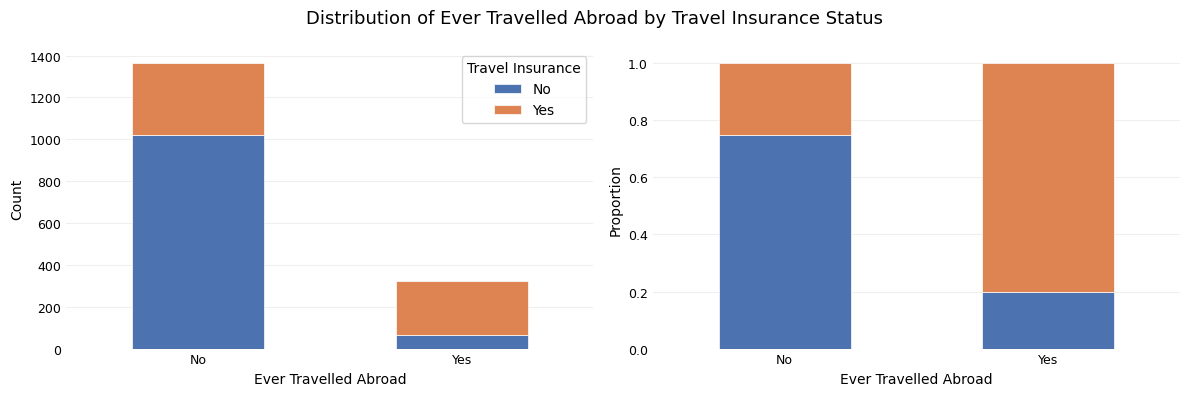

Ever Travelled Abroad - Travel Insurance:
Chi-Square test p-value: 0.00



In [14]:
categorical_relationships(customers)

Observations:
- Individuals in the private sector or self-employed, frequent fliers, and those with previous international travel experience are more likely to purchase travel insurance.
- There is no significant difference in travel insurance purchase behavior based on education level and the presence of chronic disease.

## Relationships Between Predictors

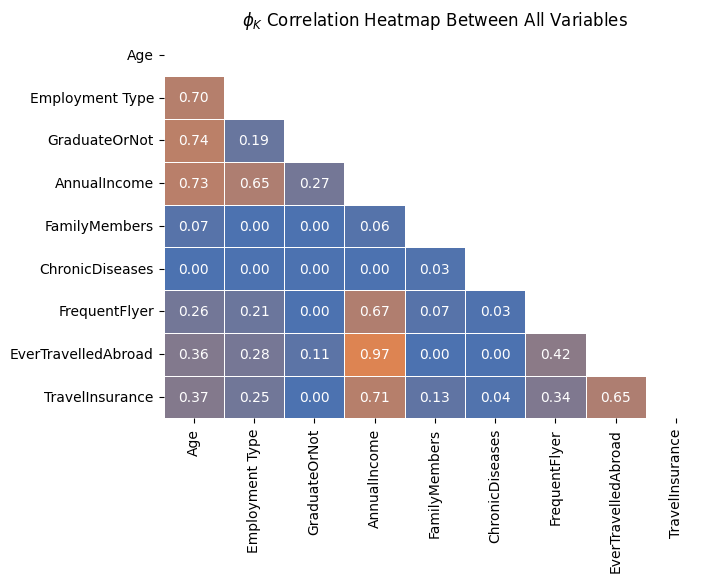

In [15]:
colors = ['#4C72B0', '#DD8452']
n_bins = [0, 1]
cmap = LinearSegmentedColormap.from_list('custom_blue', list(zip(n_bins, colors)))
phik_matrix = customers.phik_matrix(interval_cols=numerical_cols)
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
plt.figure(figsize=(7, 5))
sns.heatmap(
    phik_matrix, mask=mask, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, cbar=False
)
plt.title(r'$\phi_K$ Correlation Heatmap Between All Variables');

Observations:
- Age and employment type have a few high correlations, but annual income has high correlations with most features, especially the near-perfect correlation with "ever traveled abroad" (0.97). This may indicate that annual income is multicorrelated.

Impact:
- I will calculate the VIF, as multicollinearity can affect the prediction accuracy of linear models and I am planning to check the performance of logistic regression.

In [16]:
X = customers.drop(columns='TravelInsurance')
y = customers['TravelInsurance']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)

numeric_features = X.select_dtypes(include='int64').columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()
preprocessor_vif = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
    ]
)
X_preprocessed = preprocessor_vif.fit_transform(X)
X_preprocessed_const = add_constant(X_preprocessed)
numeric_feature_names = numeric_features
categorical_feature_names = list(
    preprocessor_vif.named_transformers_['cat'].get_feature_names_out(
        categorical_features
    )
)
all_feature_names = ['const'] + numeric_feature_names + categorical_feature_names
vif_data = pd.DataFrame()
vif_data['Feature'] = all_feature_names
vif_data['VIF'] = [
    variance_inflation_factor(X_preprocessed_const, i)
    for i in range(X_preprocessed_const.shape[1])
]
vif_data

,Feature,VIF
0,const,12.349978
1,Age,1.013229
2,AnnualIncome,1.589009
3,FamilyMembers,1.002218
4,Employment Type_Private Sector/Self Employed,1.191729
5,GraduateOrNot_Yes,1.051080
6,ChronicDiseases_Yes,1.002965
7,FrequentFlyer_Yes,1.161860
8,EverTravelledAbroad_Yes,1.359551


Observations:
- No multicollinearity.

## Summary

No major issues with the data were found.

Based on the EDA, the insights are:
- Individuals who purchase travel insurance are more likely to be privately employed or self-employed rather than government employees.
- Having a high income is a good indicator of someone buying travel insurance.
- Frequent fliers are more inclined to buy travel insurance.
- Those who have traveled abroad before are more likely to purchase travel insurance.
- There is no statistically significant difference in travel insurance purchase behavior between graduates and non-graduates.
- The presence of a chronic disease does not show a statistically significant association with the likelihood of purchasing travel insurance.
- Age is not a statistically significant predictor for buying travel insurance.
- The number of family members is not statistically significantly related to buying travel insurance.

# Machine Learning

The main objectives for this part of the notebook are:

- Select three well performing models.
- Tune hyperparameters and threshold of the selected models.
- Ensemble the models.

As mentioned in the Readme, we will evaluate model performance based on the F1 score for the positive class.

## Baseline with Dummy Classifier

In [17]:
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='macro'),
    'f1_yes': make_scorer(f1_score, pos_label=1),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
strategies = ['stratified', 'most_frequent', 'prior', 'uniform']
for strategy in strategies:
    dummy = DummyClassifier(strategy=strategy, random_state=5)
    cv_scores = cross_validate(dummy, X, y, cv=cv, scoring=scoring)
    accuracy = cv_scores['test_accuracy'].mean()
    macro_f1 = cv_scores['test_f1'].mean()
    f1_yes = cv_scores['test_f1_yes'].mean()
    print(f"Strategy: {strategy}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Macro F1: {macro_f1:.2f}")
    print(f"F1 for Yes: {f1_yes:.2f}\n")

Strategy: stratified
Accuracy: 0.55
Macro F1: 0.50
F1 for Yes: 0.36

Strategy: most_frequent
Accuracy: 0.64
Macro F1: 0.39
F1 for Yes: 0.00

Strategy: prior
Accuracy: 0.64
Macro F1: 0.39
F1 for Yes: 0.00

Strategy: uniform
Accuracy: 0.49
Macro F1: 0.48
F1 for Yes: 0.42



Observations:
- After evaluating various dummy classifiers, the "uniform" classifier has the highest F1 score of 0.42 and an overall accuracy of 0.49. Future models should aim to surpass this.

## Model Selection

There is no existing function to split the data as described in the section about duplicates. Consequently, all modeling steps will have to be executed without the help of very usefull sklearn functions, resulting in more code.

In [18]:
numeric_features = X.select_dtypes(include='int64').columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline(
                steps=[
                    ('log', FunctionTransformer(np.log1p, validate=True)),
                    ('scaler', StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        ('cat', OneHotEncoder(), categorical_features),
    ]
)
models = {
    'RandomForest': RandomForestClassifier(random_state=5),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier(random_state=5),
    'LogisticRegression': LogisticRegression(),
}
kf = KFold(n_splits=5, shuffle=True, random_state=5)
for model_name, single_model in models.items():
    train_scores = []
    test_scores = []
    train_macro_f1_scores = []
    test_macro_f1_scores = []
    train_f1_yes_scores = []
    test_f1_yes_scores = []
    pipeline_for_all_models = Pipeline(
        steps=[('preprocessor', preprocessor), ('classifier', single_model)]
    )
    unique_customers = customers.drop_duplicates().reset_index(drop=True)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(unique_customers):
        train_customers = unique_customers.iloc[train_index]
        test_customers = unique_customers.iloc[test_index]
        X_train = X[X.index.isin(train_customers.index)]
        y_train = y[X_train.index]
        X_test = X[X.index.isin(test_customers.index)]
        y_test = y[X_test.index]
        pipeline_for_all_models.fit(X_train, y_train)
        y_train_pred = pipeline_for_all_models.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_score)
        train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
        train_macro_f1_scores.append(train_macro_f1)
        train_f1_yes = f1_score(y_train, y_train_pred, pos_label=1)
        train_f1_yes_scores.append(train_f1_yes)
        y_test_pred = pipeline_for_all_models.predict(X_test)
        test_score = accuracy_score(y_test, y_test_pred)
        test_scores.append(test_score)
        test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
        test_macro_f1_scores.append(test_macro_f1)
        test_f1_yes = f1_score(y_test, y_test_pred, pos_label=1)
        test_f1_yes_scores.append(test_f1_yes)
    average_train_score = np.mean(train_scores)
    average_test_score = np.mean(test_scores)
    average_train_macro_f1 = np.mean(train_macro_f1_scores)
    average_test_macro_f1 = np.mean(test_macro_f1_scores)
    average_train_f1_yes = np.mean(train_f1_yes_scores)
    average_test_f1_yes = np.mean(test_f1_yes_scores)
    print(f'{model_name}')
    print(
        f'Train: Accuracy {average_train_score:.2f}, Macro F1 {average_train_macro_f1:.2f}, F1 for Yes {average_train_f1_yes:.2f}'
    )
    print(
        f'Test: Accuracy {average_test_score:.2f}, Macro F1 {average_test_macro_f1:.2f}, F1 for Yes {average_test_f1_yes:.2f}\n'
    )

RandomForest
Train: Accuracy 0.94, Macro F1 0.93, F1 for Yes 0.91
Test: Accuracy 0.78, Macro F1 0.75, F1 for Yes 0.67

SVM
Train: Accuracy 0.82, Macro F1 0.78, F1 for Yes 0.70
Test: Accuracy 0.80, Macro F1 0.76, F1 for Yes 0.67

KNN
Train: Accuracy 0.83, Macro F1 0.81, F1 for Yes 0.74
Test: Accuracy 0.77, Macro F1 0.74, F1 for Yes 0.65

NaiveBayes
Train: Accuracy 0.73, Macro F1 0.69, F1 for Yes 0.59
Test: Accuracy 0.73, Macro F1 0.69, F1 for Yes 0.58

GradientBoosting
Train: Accuracy 0.85, Macro F1 0.82, F1 for Yes 0.75
Test: Accuracy 0.83, Macro F1 0.79, F1 for Yes 0.71

LogisticRegression
Train: Accuracy 0.77, Macro F1 0.71, F1 for Yes 0.59
Test: Accuracy 0.76, Macro F1 0.70, F1 for Yes 0.58



Impact:
- Based on the F1 score, the selected best models are RandomForest, KNN, and GradientBoosting.
- All algorithms are performing better than the dummy classifiers.

*Note from the future: Instead of KNN, SVM should have been selected. This decision was influenced by uncertainty on how to handle duplicates, leading to multiple code revisions. SVM typically doesn't use probabilities, and since the necessary functions for the project were already written, I decided to not redo part of the project.*

## Model Tuning

Results will be discused at the end of this sub-section.

### Random Forest

In [19]:
preprocessor_no_numeric_transformation = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_features)],
    remainder='passthrough',
)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'class_weight': [None, {0: 1, 1: 2}],
}
best_params_rf = tune_hyperparameters(
    preprocessor_no_numeric_transformation,
    param_grid_rf,
    RandomForestClassifier,
    customers,
)

Best parameters found: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}
Best cross-validated F1 for Yes category: 0.69


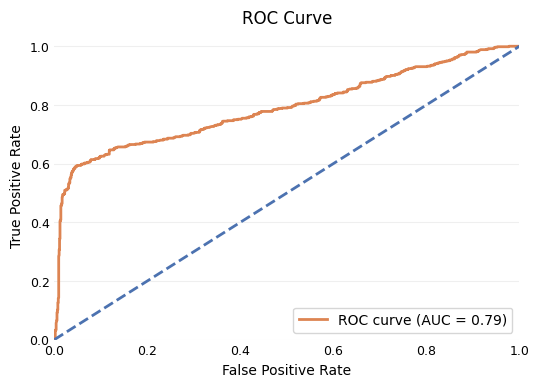

Best Threshold for F1 Score: 0.47
F1 Score at Best Threshold: 0.71


In [20]:
threshold_rf = tune_threshold(
    preprocessor_no_numeric_transformation, best_params_rf, RandomForestClassifier, X, y
)

Classification Report (Threshold = 0.47):
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87      1085
         1.0       0.87      0.58      0.70       603

    accuracy                           0.82      1688
   macro avg       0.84      0.77      0.79      1688
weighted avg       0.83      0.82      0.81      1688



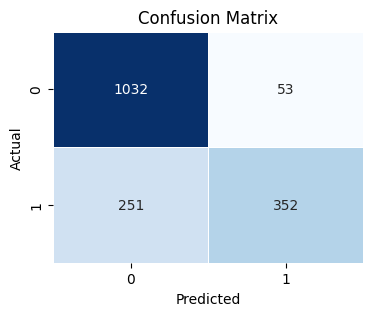

In [21]:
pipeline_rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor_no_numeric_transformation),
        ('classifier', RandomForestClassifier(**best_params_rf)),
    ]
)
evaluate_model_with_threshold(pipeline_rf, threshold_rf, X, y)

### K-Nearest Neighbors

In [22]:
param_grid_knn = {
    'n_neighbors': list(range(1, 15)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': [None, 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}
best_params_knn = tune_hyperparameters(
    preprocessor, param_grid_knn, KNeighborsClassifier, customers
)

Best parameters found: {'n_neighbors': 9, 'metric': 'euclidean', 'weights': None, 'algorithm': 'ball_tree'}
Best cross-validated F1 for Yes category: 0.67


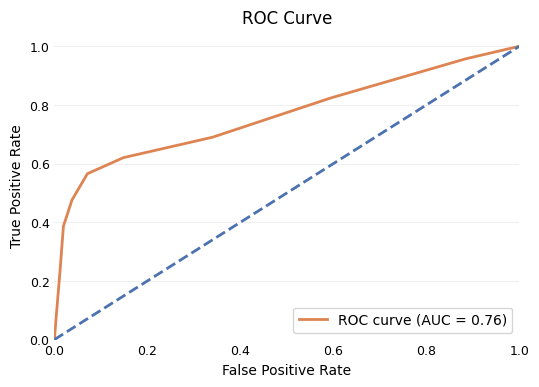

Best Threshold for F1 Score: 0.56
F1 Score at Best Threshold: 0.67


In [23]:
threshold_knn = tune_threshold(
    preprocessor, best_params_knn, KNeighborsClassifier, X, y
)

Classification Report (Threshold = 0.56):
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86      1085
         1.0       0.82      0.57      0.67       603

    accuracy                           0.80      1688
   macro avg       0.80      0.75      0.76      1688
weighted avg       0.80      0.80      0.79      1688



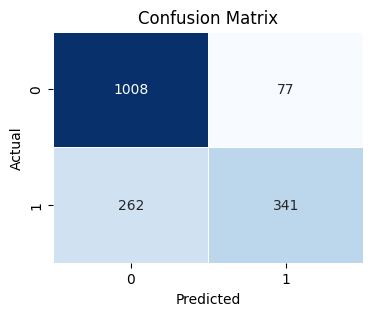

In [24]:
pipeline_knn = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(**best_params_knn)),
    ]
)
evaluate_model_with_threshold(pipeline_knn, threshold_knn, X, y)

### Gradient Boosting

In [25]:
param_grid_gbc = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
}
best_params_gbc = tune_hyperparameters(
    preprocessor, param_grid_gbc, GradientBoostingClassifier, customers
)

Best parameters found: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0}
Best cross-validated F1 for Yes category: 0.71


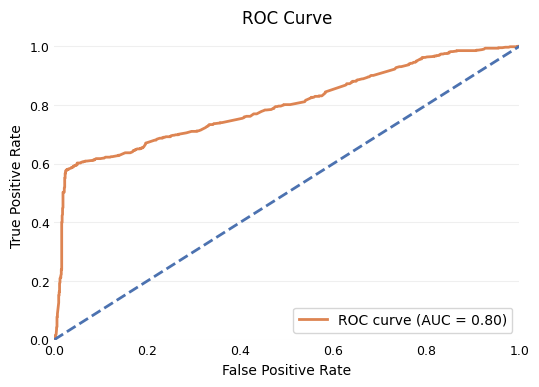

Best Threshold for F1 Score: 0.37
F1 Score at Best Threshold: 0.71


In [26]:
threshold_gbc = tune_threshold(
    preprocessor, best_params_gbc, GradientBoostingClassifier, X, y
)

Classification Report (Threshold = 0.37):
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88      1085
         1.0       0.87      0.60      0.71       603

    accuracy                           0.83      1688
   macro avg       0.84      0.78      0.79      1688
weighted avg       0.83      0.83      0.82      1688



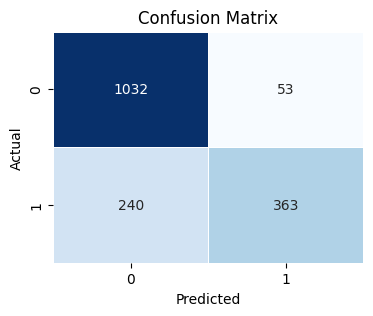

In [27]:
pipeline_gbc = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(**best_params_gbc)),
    ]
)
evaluate_model_with_threshold(pipeline_gbc, threshold_gbc, X, y)

### Results

- After tuning, there was a slight increase in performance, with improvements of a few hundredths in the F1 score. However, the tuning did not improve the performance of the Gradient Boosting model.
- Overall, the effectiveness of all models is similar, with F1 scores around 0.7, with KNN being the worst.
- All models have high precision but much lower recall. When one of these scores is high, the other one being low is expected due to the trade-off.

## Ensemble Model Testing

I will use a simple averaging voting strategy.

In [28]:
unique_customers = pd.DataFrame(X).drop_duplicates().reset_index(drop=True)
ensemble_f1_scores = []
pipeline_gbc.named_steps['classifier'].set_params(random_state=5)
pipeline_rf.named_steps['classifier'].set_params(random_state=5)
unique_customers = customers.drop_duplicates().reset_index(drop=True)
kf = KFold(n_splits=5, shuffle=True, random_state=5)
for train_index, test_index in kf.split(unique_customers):
    train_customers = unique_customers.iloc[train_index]
    test_customers = unique_customers.iloc[test_index]
    X_train = X[X.index.isin(train_customers.index)]
    y_train = y[X_train.index]
    X_test = X[X.index.isin(test_customers.index)]
    y_test = y[X_test.index]
    pipeline_gbc.fit(X_train, y_train)
    pipeline_rf.fit(X_train, y_train)
    pipeline_knn.fit(X_train, y_train)
    gbc_probs = pipeline_gbc.predict_proba(X_test)[:, 1]
    rf_probs = pipeline_rf.predict_proba(X_test)[:, 1]
    knn_probs = pipeline_knn.predict_proba(X_test)[:, 1]
    gbc_preds = (gbc_probs >= threshold_gbc).astype(int)
    rf_preds = (rf_probs >= threshold_rf).astype(int)
    knn_preds = (knn_probs >= threshold_knn).astype(int)
    ensemble_preds = (gbc_preds + rf_preds + knn_preds) / 3
    ensemble_preds = (ensemble_preds >= 0.5).astype(int)
    ensemble_f1 = f1_score(y_test, ensemble_preds)
    ensemble_f1_scores.append(ensemble_f1)
average_ensemble_f1 = np.mean(ensemble_f1_scores)
print(f"Average Ensemble F1 score: {round(average_ensemble_f1,2)}")

Average Ensemble F1 score: 0.71


Observations:
- The F1 score matches the result of the best-performing individual model, Gradient Boosting. 

To see how successfull is ensemble model on the holdout test set, I will first apply all the changes previously made to the main dataset.

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       192
           1       0.86      0.60      0.71       107

    accuracy                           0.82       299
   macro avg       0.84      0.77      0.79       299
weighted avg       0.83      0.82      0.81       299



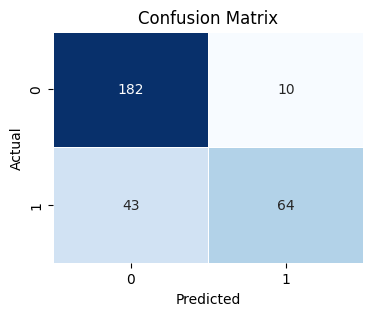

In [29]:
customers_holdout_test = customers_holdout_test.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col
)
binary_columns = ['ChronicDiseases', 'TravelInsurance']
customers_holdout_test[binary_columns] = customers_holdout_test[binary_columns].apply(
    lambda col: col.astype('category')
)
customers_holdout_test['ChronicDiseases'] = customers_holdout_test[
    'ChronicDiseases'
].cat.rename_categories({0: 'No', 1: 'Yes'})
customers_holdout_test['TravelInsurance'] = customers_holdout_test[
    'TravelInsurance'
].cat.rename_categories({0: 'No', 1: 'Yes'})
X_holdout_test = customers_holdout_test.drop(columns='TravelInsurance')
y_holdout_test = customers_holdout_test['TravelInsurance']
X_holdout_test.reset_index(drop=True, inplace=True)
y_holdout_test.reset_index(drop=True, inplace=True)
label_encoder = LabelEncoder()
y_holdout_test = pd.Series(
    label_encoder.fit_transform(y_holdout_test), index=y_holdout_test.index
)
gbc_probs_holdout = pipeline_gbc.predict_proba(X_holdout_test)[:, 1]
rf_probs_holdout = pipeline_rf.predict_proba(X_holdout_test)[:, 1]
knn_probs_holdout = pipeline_knn.predict_proba(X_holdout_test)[:, 1]
gbc_preds_holdout = (gbc_probs_holdout >= threshold_gbc).astype(int)
rf_preds_holdout = (rf_probs_holdout >= threshold_rf).astype(int)
knn_preds_holdout = (knn_probs_holdout >= threshold_knn).astype(int)
ensemble_preds_holdout = (gbc_preds_holdout + rf_preds_holdout + knn_preds_holdout) / 3
ensemble_preds_holdout = (ensemble_preds_holdout >= 0.5).astype(int)
print(classification_report(y_holdout_test, ensemble_preds_holdout))
plot_confusion(y_holdout_test, ensemble_preds_holdout)

Observations:
- An unbiased evaluation of the model's efficiency on unseen data shows that the scores are very close to those obtained on the training data for the Gradient Boosting algorithm. This is a positive outcome, as it suggests that the model's effectiveness did not fell when evaluated on unseen data.
- The model has a high precision but lower recall. If needed, the model could be adjusted to have very high precision by modifying the threshold.

# Conclusions

If I were to spend more time on this project, my first steps would be:
1. Determine if building an ensemble was worthwhile, I could test how individual models perform on the holdout set to see if their scores are lower.
2. Check if different ensemble strategies enhance model performance since the simple averaging voting strategy is generally considered a starting point.

Other ideas about the project:
- Classification scores could still be improved by trying out more hyperparameters. I avoided large combinations to speed up the process.
- To do a good project, I would need to research the business case. This context would help ensure the model addresses actual practical problems.
- Check if adding a measure to address class imbalances improves the performance of KNN and Gradient Boosting algorithms.
- The main way to further improve the model would be to do feature engineering.
- I did not plot PR curves, as this information was not very useful for me. However, including them might be a good idea since other people (stakeholders) may be interested.
- It might be interesting to check performance metrics for the ensemble: ROC-AUC and PR curves.
- I am still unsure if I used the correct approach to handling duplicates, as this is a contentious topic.